In [2]:
# Importing the files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Install required libraries
!pip install -q -U watermark
!pip install -q transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.8 MB/s eta 0:00:00


In [4]:
#Import libraries
import os
import pandas as pd
from transformers import pipeline
from textwrap import wrap
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Define folder path
folder_path = '/content/drive/MyDrive/Bert_sentiment_texts'

# Load all .txt files
txt_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]

# Helper to chunk text (~512 characters max for BERT)
def chunk_text(text, max_length=512):
    return wrap(text, width=max_length)

# Load and chunk each file's text
data = []
for file in txt_files:
    with open(os.path.join(folder_path, file), 'r', encoding='utf-8') as f:
        full_text = f.read()
        chunks = chunk_text(full_text)
        data.append({'filename': file, 'chunks': chunks})

In [7]:
# Load BERT classifier
classifier = pipeline("sentiment-analysis")

# Analyze each chunk and collect sentiment + score
results = []

for entry in data:
    sentiments = []
    for chunk in entry['chunks']:
        result = classifier(chunk)[0]
        sentiments.append(result)

    # Calculate summary stats
    total = len(sentiments)
    positives = [s for s in sentiments if s['label'] == 'POSITIVE']
    negatives = [s for s in sentiments if s['label'] == 'NEGATIVE']

    positive_pct = len(positives) / total * 100
    negative_pct = len(negatives) / total * 100
    avg_score = sum([s['score'] for s in sentiments]) / total

    results.append({
        'filename': entry['filename'],
        'total_chunks': total,
        'positive_pct': positive_pct,
        'negative_pct': negative_pct,
        'avg_confidence': avg_score
    })

# Convert to DataFrame
summary_df = pd.DataFrame(results)
summary_df.head()


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


,filename,total_chunks,positive_pct,negative_pct,avg_confidence
0,Chem Unbound Transcripts S22 (1).txt,106,39.622642,60.377358,0.946033
1,merged_file.txt,273,49.450549,50.549451,0.948062
2,TRANSCRIPT_2_23 (1).txt,53,49.056604,50.943396,0.943880


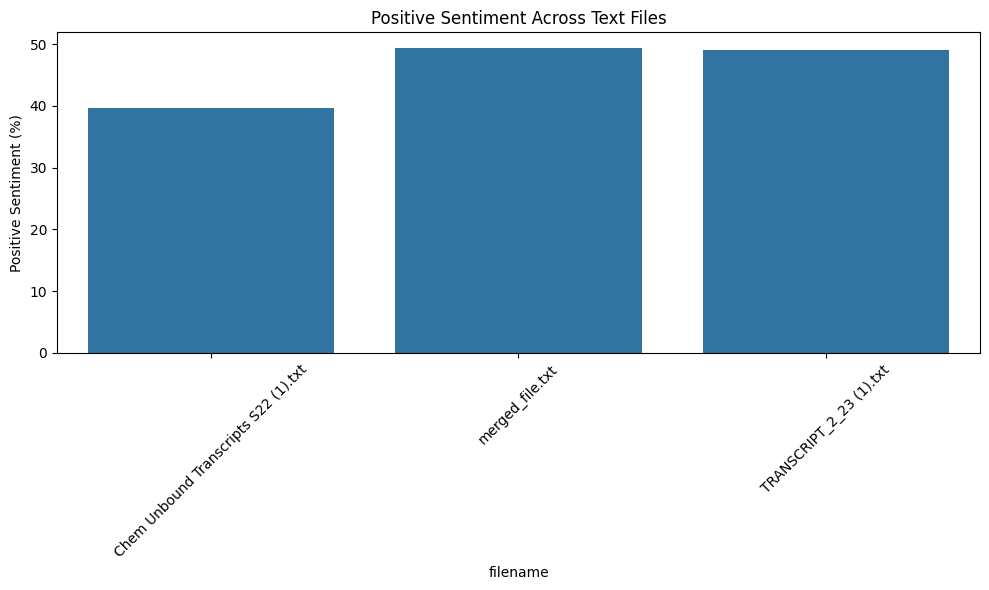

In [8]:
# Plot % of positive sentiment across files
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_df, x='filename', y='positive_pct')
plt.xticks(rotation=45)
plt.ylabel('Positive Sentiment (%)')
plt.title('Positive Sentiment Across Text Files')
plt.tight_layout()
plt.show()


In [9]:
output_path = '/content/drive/MyDrive/bert_sentiment_summary.csv'
summary_df.to_csv(output_path, index=False)
print(f"Results saved to {output_path}")

Results saved to /content/drive/MyDrive/bert_sentiment_summary.csv
